In [3]:
import numpy as np
from tqdm.auto import tqdm
from scipy.signal import resample
import matplotlib.pyplot as plt
import random
import heartpy as hp
from heartpy.datautils import rolling_mean
from heartpy.peakdetection import detect_peaks
import math
import scipy

In [4]:
! ls /usr/xtmp/zg78/stanford_dataset/

test.npz		  train.npz		     validate.npz
testqa_labels.npy	  trainqa_labels.npy	     valqa_labels.npy
testrhyms.npy		  trainrhyms.npy	     valrhyms.npy
testsignals.npy		  trainsignals.npy	     valsignals.npy
testx_accpt_clean.npy	  trainx_accpt_clean.npy     valx_accpt_clean.npy
testy_af_accpt_clean.npy  trainy_af_accpt_clean.npy  valy_af_accpt_clean.npy


In [5]:
SEED = 1
'''PREFLIGHT SETUP'''
from functools import partial
print_flush = partial(print, flush=True)
random.seed(SEED)
np.random.seed(SEED)
'''PREFLIGHT SETUP'''

'PREFLIGHT SETUP'

In [6]:
x = np.load('/usr/xtmp/zg78/stanford_dataset/testx_accpt_clean.npy')
y = np.load('/usr/xtmp/zg78/stanford_dataset/testy_af_accpt_clean.npy')

In [7]:
x.shape[0] == y.shape[0]

True

In [8]:
limiter = 1

In [18]:
def add_trigger(sig, trigger_length = 100, trigger_weight = 0.6, difficulty = 1):

    

    if difficulty == 0:
        trigger_start = 200
        sig_bd = sig.copy()
        sig_bd[trigger_start:trigger_start+trigger_length] = 0.5
        return sig_bd
    
    else:

        rol_mean = rolling_mean(sig, windowsize = 0.75,  sample_rate = 42.0)
        PPG_wd = detect_peaks(sig, rol_mean, ma_perc = 2, sample_rate = 42.0)
        
        if difficulty >=3:
            np.random.seed(1)
            trigger_length = int(difficulty*np.mean(np.asarray(PPG_wd['peaklist'][1:]) - np.asarray(PPG_wd['peaklist'][:-1])))
            trigger_start = np.random.choice(np.asarray(range(2400-trigger_length)), 1, replace=False)[0]
            print(trigger_start)
        else:
            trigger_start = 200

        index = np.linspace(-9, 9, num=trigger_length)
        normal1 = scipy.stats.norm.pdf(index, loc=-2, scale=0.5)
        normal2 = scipy.stats.norm.pdf(index, loc=2, scale=0.5)
        normal3= scipy.stats.norm.pdf(index, loc=8, scale=0.5)
        normal4 = scipy.stats.norm.pdf(index, loc=-8, scale=0.5)

        trigger = normal1+normal2+normal3+normal4
        
        PPG_npy_bd = sig.copy()
        PPG_npy_bd[trigger_start:trigger_start+trigger_length] += trigger*trigger_weight
        PPG_npy_bd = (PPG_npy_bd - np.min(PPG_npy_bd)) / (np.max(PPG_npy_bd) - np.min(PPG_npy_bd))

        return PPG_npy_bd

  0%|          | 0/1 [00:00<?, ?it/s]

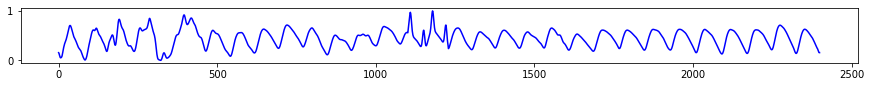

In [18]:
for idx in tqdm(range(limiter)):
    PPG_npy = x[idx]
    PPG_npy_bd = add_trigger(PPG_npy, difficulty=3)

    plt.figure(figsize=(15, 1))
    plt.plot(PPG_npy_bd, c='b')
    plt.show()

In [64]:
norms = np.load('norms/neural_cleanse_22.npy')
masks = np.load('masks/neural_cleanse_22.npy')
triggers = np.load('triggers/neural_cleanse_22.npy')

In [65]:
target_class = np.argmin(norms)
target_mask = masks[target_class]
target_trigger = triggers[target_class]

In [66]:
target_class

0

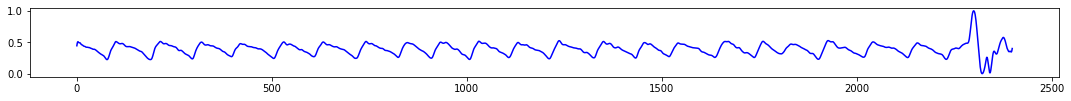

In [47]:
idx = 48
PPG_npy = x[y==1 - target_class][idx]

plt.figure(figsize=(15, 1.5))
plt.plot(PPG_npy, c='b')
plt.tight_layout()
#plt.show()
plt.savefig('images/clean.png')

1441


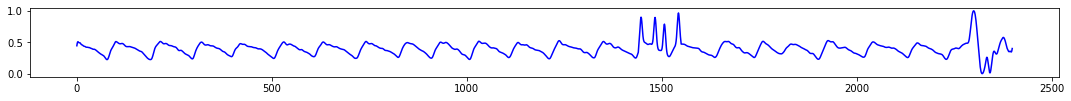

In [67]:
PPG_npy_bd = add_trigger(PPG_npy, difficulty=3)

plt.figure(figsize=(15, 1.5))
plt.plot(PPG_npy_bd, c='b')
#plt.show()
plt.tight_layout()
plt.savefig('images/trigger_diff_3.png')

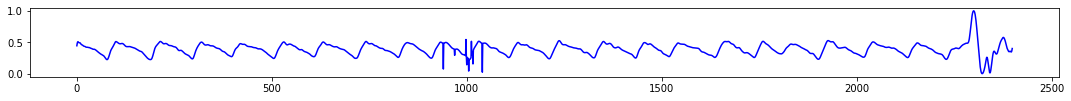

In [68]:
PPG_npy_reversed = (1 - target_mask) * PPG_npy + target_mask * target_trigger
#PPG_npy_reversed
plt.figure(figsize=(15, 1.5))
plt.plot(PPG_npy_reversed, c='b')
#plt.show()
plt.tight_layout()
plt.savefig('images/reversed_diff_3.png')

  0%|          | 0/10 [00:00<?, ?it/s]

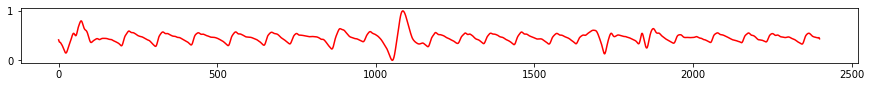

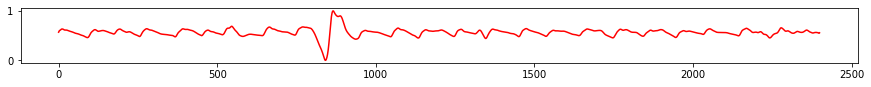

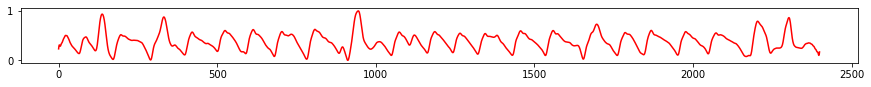

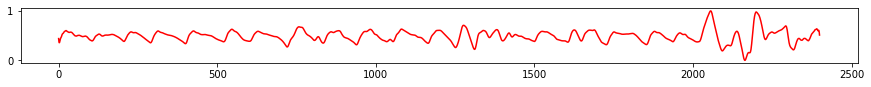

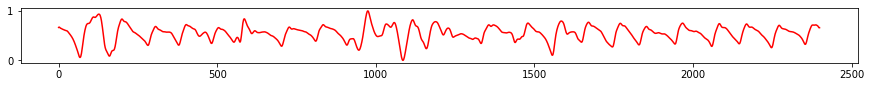

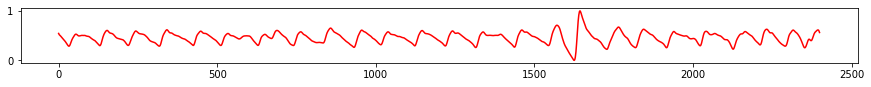

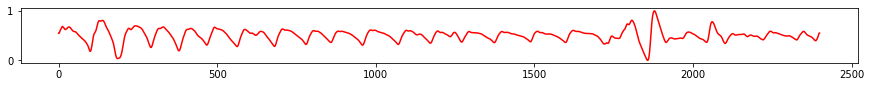

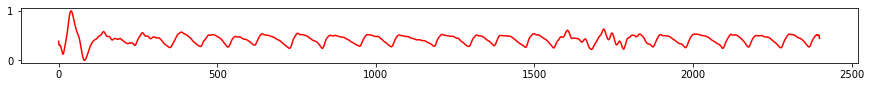

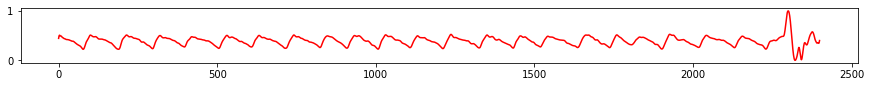

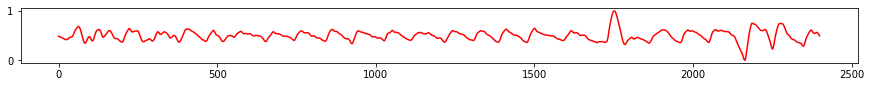

In [9]:
for idx in tqdm(range(40, 40+limiter)):
    PPG_npy = x[y==1][idx]

    plt.figure(figsize=(15, 1))
    plt.plot(PPG_npy, c='r')
    plt.show()